In [ ]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 42.7 MB/s eta 0:00:00


<ipython-input-16-0e343732739d>:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.92` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


GPT-2 Insight:
 New anomaly detected: Metrics anomaly at 2023-12-01 00:00:00: CPU usage 39.69%, Memory usage 99.76%
What is the likely cause and possible solution for this anomaly?
The following is a list of possible solutions.
1. The CPU is not running at full speed. This is because the CPU has been idle for a long time. 2. There is no way to detect the anomaly. 3. CPU utilization is low. 4. It is possible that the GPU is running too fast. 5. GPU utilization may be low, but it is unlikely that it will be. 6. If the problem is detected, the system will not be able to run. 7. A CPU that is idle is likely to be running a lot of CPU. 8. In the event of a CPU failure, it may not work. 9. An anomaly may occur. 10. Some of the data may have been lost. 11. All of these scenarios are possible. 12. Please note that this is only a hypothesis. 13. We do not know the exact cause of this problem. 14. Any other possible causes are not possible at this time, and we do have no idea what the cause is. 

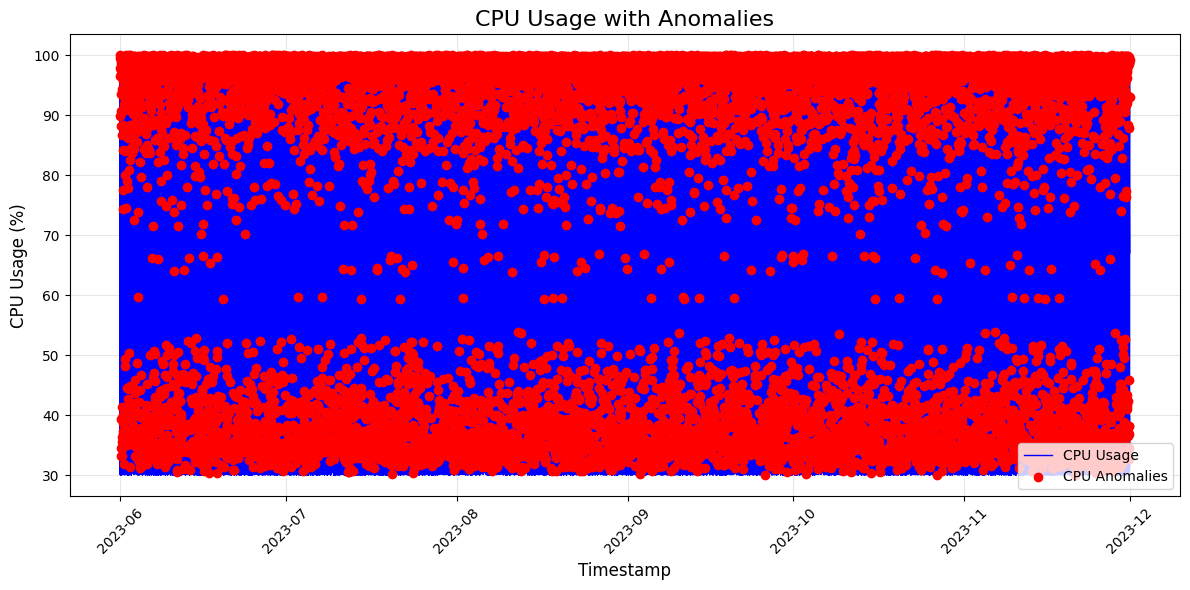

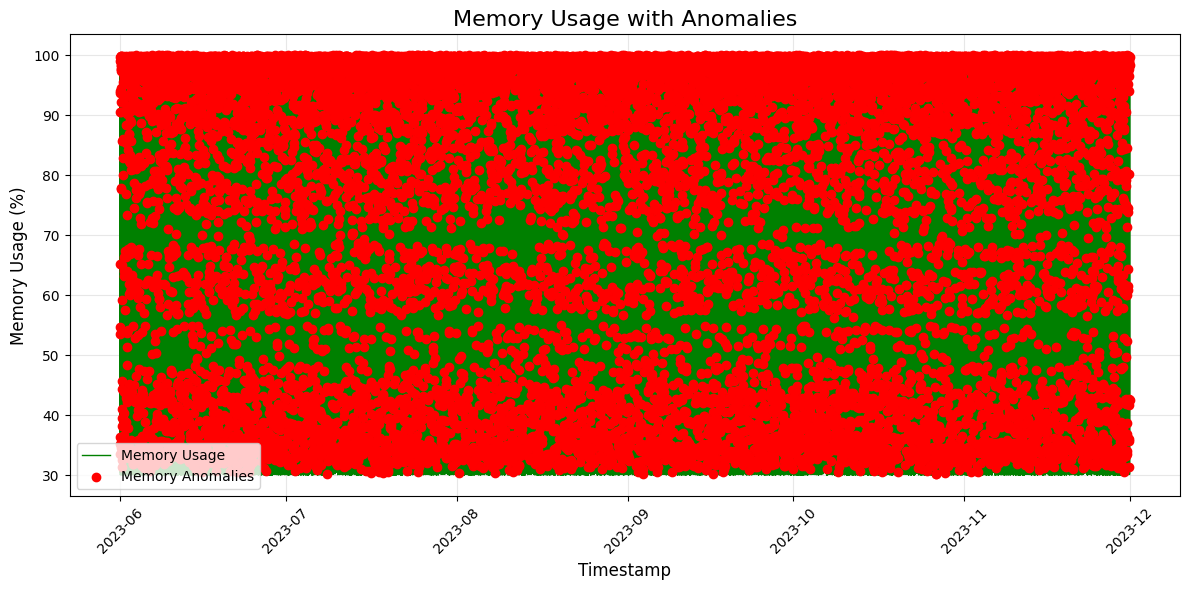

In [16]:

import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
from sklearn.ensemble import IsolationForest
from sentence_transformers import SentenceTransformer
import faiss
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import matplotlib.pyplot as plt

# --- Load Data ---
def load_data(file_path='synthetic_data.csv'):

    data = pd.read_csv(file_path)
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    return data

# --- Process Data ---
def process_data(data):

    data.sort_values(by='timestamp', inplace=True)
    data.fillna(method='ffill', inplace=True)
    return data

# --- Train Model with Test Data ---
def train_model_with_test_data(data):

    metrics_features = data[['cpu_usage', 'memory_usage']]
    isolation_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
    data['anomaly'] = (isolation_forest.fit_predict(metrics_features) == -1).astype(int)
    return isolation_forest, data

# --- Train Model with Clean Data ---
def train_model_with_clean_data(data):

    metrics_features = data[['cpu_usage', 'memory_usage']]
    isolation_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
    data['anomaly'] = (isolation_forest.fit_predict(metrics_features) == -1).astype(int)
    return isolation_forest, data

# --- Process Anomalies ---
def process_anomalies(data):

    detected_anomalies = data[data['anomaly'] == 1]
    cpu_anomalies = detected_anomalies[detected_anomalies['cpu_usage'] > detected_anomalies['memory_usage']]
    memory_anomalies = detected_anomalies[detected_anomalies['memory_usage'] > detected_anomalies['cpu_usage']]

    # Combine anomalies into one DataFrame
    processed_anomalies = pd.concat([cpu_anomalies[['timestamp', 'service_name', 'cpu_usage']],
                                      memory_anomalies[['timestamp', 'service_name', 'memory_usage']]],
                                     ignore_index=False)
    return processed_anomalies, detected_anomalies

# --- GPT-2 Insight Generation ---
def generate_response(prompt, model, tokenizer, max_length=600):

    inputs = tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True)
    outputs = model.generate(inputs['input_ids'], max_length=max_length, num_return_sequences=1, no_repeat_ngram_size=2, top_p=0.92, temperature=0.7)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

# --- Build Model ---
def build_model(data, model, tokenizer):

    # Train with the cleaned data
    isolation_forest, processed_data = train_model_with_clean_data(data)

    # Process anomalies
    processed_anomalies, detected_anomalies = process_anomalies(processed_data)
    # print("\nProcessed Anomalies:")
    # print(processed_anomalies)

    # --- Handle New Anomalies ---
    new_anomalies = detected_anomalies.tail(1)
    if not new_anomalies.empty:
        for index, row in new_anomalies.iterrows():
            anomaly_description = f"Metrics anomaly at {row['timestamp']}: CPU usage {row['cpu_usage']:.2f}%, Memory usage {row['memory_usage']:.2f}%"
            # print(f"\nNew Detected Anomaly: {anomaly_description}")

            # Create the GPT-2 prompt
            prompt = f"New anomaly detected: {anomaly_description}\nWhat is the likely cause and possible solution for this anomaly?"

            # Generate GPT-2 response (insight or solution)
            insight = generate_response(prompt, model, tokenizer)
            print("GPT-2 Insight:\n", insight)

    return isolation_forest, processed_data, processed_anomalies

# --- Visualize Data ---
def visualize_data(data, processed_anomalies):

    # Plot CPU usage with anomalies
    plt.figure(figsize=(12, 6))
    plt.plot(data['timestamp'], data['cpu_usage'], label='CPU Usage', color='blue', linewidth=1)
    plt.scatter(processed_anomalies['timestamp'], processed_anomalies['cpu_usage'], color='red', label='CPU Anomalies', zorder=3)
    plt.title('CPU Usage with Anomalies', fontsize=16)
    plt.xlabel('Timestamp', fontsize=12)
    plt.ylabel('CPU Usage (%)', fontsize=12)
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot Memory usage with anomalies
    plt.figure(figsize=(12, 6))
    plt.plot(data['timestamp'], data['memory_usage'], label='Memory Usage', color='green', linewidth=1)
    plt.scatter(processed_anomalies['timestamp'], processed_anomalies['memory_usage'], color='red', label='Memory Anomalies', zorder=3)
    plt.title('Memory Usage with Anomalies', fontsize=16)
    plt.xlabel('Timestamp', fontsize=12)
    plt.ylabel('Memory Usage (%)', fontsize=12)
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# --- Example Usage ---
if __name__ == "__main__":
    # Load the synthetic data
    data = load_data()

    # Process the data (handling missing values and sorting)
    processed_data = process_data(data)

    # Load GPT-2 model and tokenizer
    model = GPT2LMHeadModel.from_pretrained("gpt2")
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

    # Build and train the model using clean data and generate GPT-2 insights
    isolation_forest, processed_data, processed_anomalies = build_model(processed_data, model, tokenizer)

    # Visualize the data and anomalies
    visualize_data(processed_data, processed_anomalies)
